In [2]:
%matplotlib inline
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import backtrader as bt
#import pyfolio as pf

import backtrader.plot.formatters as fmt
import backtrader.plot.locator as loc
import numpy as np
import matplotlib.pyplot as plt
import MyUtils
import CurrencyAdjuster

In [34]:
class BenchmarkStrat(bt.Strategy):

    def __init__(self):
        self.stratname = 'Benchmark'
        self.smaVTSMX = bt.indicators.SimpleMovingAverage(self.datas[3], period=8)
        self.invested=False
        self.lastmonth=None

    def notify_order(self, order):
        if order.status == order.Completed:
            pass
        if not order.alive():
            self.order = None  # indicate no order is pending
    def start(self):
        self.order = None

    def next(self):         
        dt = datetime.datetime.fromordinal(int(self.datas[0].datetime[0]))
        mon = dt.month
        usdchf = self.dnames['USDCHF'].close[0]
        #usdchf = 1
        if self.invested==False: #we are not invested yet
            self.broker.set_cash(100000/usdchf)
            print("BEN: Set initial cash value to %.2f" % self.broker.get_value())
            self.invested=True
        
        if mon != self.lastmonth: #This is the last trading day of the month and we determine what we order
            self.broker.add_cash(1000/usdchf)
            portfolio_value = self.broker.get_value()
            self.order_target_value(self.dnames['Benchmark'], target=portfolio_value - 4000.0)
            self.lastmonth=dt.month

class TimingSMASingle(bt.Strategy):
    def __init__(self):
        self.smaVEURX = bt.indicators.SimpleMovingAverage(self.datas[3], period=8)
        self.outofmarket = True
        self.stratname = 'SMASingleEUR'
        self.invested=False
        self.lastmonth=None

    def notify_order(self, order):
        if order.status == order.Completed:
            pass
        if not order.alive():
            self.order = None  # indicate no order is pending
    def start(self):
        self.order = None
        
    def next(self):
        dt = datetime.datetime.fromordinal(int(self.datas[0].datetime[0]))
        mon = dt.month
        usdchf = self.dnames['USDCHF'].close[0]
        
        if self.invested==False: #we are not invested yet
            self.broker.set_cash(100000/usdchf)
            print("SIN: Set initial cash value to %.2f" % self.broker.get_value())
            self.invested=True
        
        if mon != self.lastmonth: #This is the last trading day of the month and we determine what we order
            self.broker.add_cash(1000/usdchf)
            lastclose = self.datas[3].close[0]
            smaval = self.smaVEURX[0]
            equity_value = self.broker.get_value([self.dnames['VEURX']])
            bond_value = self.broker.get_value([self.dnames['VBMFX']])
            portfolio_value = self.broker.get_value()
            trading = False
            if (1*smaval) > lastclose and self.outofmarket==False:
                self.order_target_value(self.dnames['VEURX'], target=0.0)
                self.order_target_value(self.dnames['VBMFX'], target=portfolio_value-4000.0) 
                self.outofmarket = True
                trading = True
            if smaval < lastclose and self.outofmarket==True:
                self.order_target_value(self.dnames['VBMFX'], target=0.0) 
                self.order_target_value(self.dnames['VEURX'], target=portfolio_value-4000.0) 
                self.outofmarket = False
                trading = True
            if trading:
                print('SIN %04d - %s - SMA: %.2f; C: %.2f; EqVal: %.2f; BdVal: %.2f; Cash: %.2f; PF: %.2f' %
                    (len(self), dt.date(), smaval, lastclose, equity_value, bond_value, portfolio_value-equity_value-bond_value, portfolio_value ))
                if self.outofmarket:
                    print("Leaving market on %s" % dt.date())
                else:
                    print("Entering market on %s" % dt.date())
            if trading==False: #We are not trading, just rebalance in case we are in the market:
                if self.outofmarket==False:
                    self.order_target_value(self.dnames['VEURX'], target=portfolio_value-4000.0)
                else:
                    self.order_target_value(self.dnames['VBMFX'], target=portfolio_value-4000.0)
            self.lastmonth=dt.month

class StFetcher(object):
    _STRATS = [TimingSMASingle, BenchmarkStrat]
    def __new__(cls, *args, **kwargs):
        idx = kwargs.pop('idx')
        obj = cls._STRATS[idx](*args, **kwargs)
        return obj


In [35]:
Args = {'fromdate': datetime.datetime(1999, 4, 1),
       'todate': datetime.datetime(2018, 6, 10)}

cerebro = bt.Cerebro(stdstats=False)
#cerebro.broker.setcash(100000.0)
#print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

tframes = dict(daily=bt.TimeFrame.Days, weekly=bt.TimeFrame.Weeks,
                   monthly=bt.TimeFrame.Months)

datapath = '/Users/norbert/Code/BacktesterCode/historicdata/'
data1 = bt.feeds.YahooFinanceCSVData(
        dataname=datapath + 'VEURX.csv',
        reverse=False, swapcloses=True, **Args)
data2 = bt.feeds.YahooFinanceCSVData(
        dataname=datapath + 'VBMFX.csv',
        reverse=False, swapcloses=True, adjclose=False, **Args)
BenchData = bt.feeds.YahooFinanceCSVData(
        dataname=datapath + 'VFINX.csv', 
        reverse=False, swapcloses=True, **Args)
USDCHFdata = bt.feeds.YahooFinanceCSVData(
        dataname=datapath + 'USD_CHFord.csv',
        reverse=True, swapcloses=True, adjclose=False, **Args)
data1.plotinfo.plot=False
data2.plotinfo.plot=False
BenchData.plot=False

cerebro.adddata(data1, name='VEURX')
cerebro.adddata(data2, name='VBMFX')
cerebro.adddata(BenchData, name='Benchmark')

cerebro.resampledata(data1, timeframe=tframes['monthly'], compression=1, name='VEURXm')
cerebro.resampledata(data2, timeframe=tframes['monthly'], compression=1, name='VBFMXm')
cerebro.datas[4].plotinfo.plot=False
cerebro.adddata(USDCHFdata, name='USDCHF')

cerebro.addobserver(bt.obs.Broker)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.SharpeRatio)
cerebro.addobserver(CurrencyAdjuster.PortfolioCurrencyAdjuster, data=USDCHFdata)

cerebro.optstrategy(StFetcher, idx=[0, 1])

In [36]:
results = cerebro.run(optreturn=False)

SIN: Set initial cash value to 62893.08
BEN: Set initial cash value to 62893.08
SIN 0175 - 1999-12-01 - SMA: 25.34; C: 26.76; EqVal: 0.00; BdVal: 0.00; Cash: 62893.08; PF: 62893.08
Entering market on 1999-12-01
SIN 0306 - 2000-06-01 - SMA: 27.54; C: 27.41; EqVal: 63817.32; BdVal: 0.00; Cash: 4601.71; PF: 68419.03
Leaving market on 2000-06-01
SIN 0328 - 2000-07-03 - SMA: 27.80; C: 28.03; EqVal: 0.00; BdVal: 65673.10; Cash: 6764.99; PF: 72438.09
Entering market on 2000-07-03
SIN 0349 - 2000-08-01 - SMA: 27.90; C: 27.56; EqVal: 66262.77; BdVal: 0.00; Cash: 4751.44; PF: 71014.21
Leaving market on 2000-08-01
SIN 0781 - 2002-04-01 - SMA: 19.82; C: 20.26; EqVal: 0.00; BdVal: 88442.60; Cash: 4590.24; PF: 93032.84
Entering market on 2002-04-01
SIN 0846 - 2002-07-01 - SMA: 19.85; C: 19.44; EqVal: 86730.50; BdVal: 0.00; Cash: 4657.34; PF: 91387.84
Leaving market on 2002-07-01
SIN 1064 - 2003-05-01 - SMA: 15.82; C: 16.70; EqVal: 0.00; BdVal: 97546.00; Cash: 4748.10; PF: 102294.10
Entering market o

In [295]:
cerebro.resampledata?

In [14]:
def GetAnnualReturns(dates,datas):
    oldyear = datetime.datetime.fromordinal(int(dates[0])).year
    yearbeginsval = datas[0]                                    
    currval = yearbeginsval
    annret_dates=np.array([])
    annret_returns=np.array([])
    i=0
    for nowdate, data in zip(dates,datas):
        prevval = currval
        curryear = datetime.datetime.fromordinal(int(nowdate)).year
        currval = data            
        if curryear > oldyear:
            #print("B %.2f, E %.2f" % (yearbeginsval,prevval) )
            annret_returns = np.append(annret_returns, (prevval - yearbeginsval - 12*1000)/yearbeginsval)
            annret_dates = np.append(annret_dates, oldyear)
            oldyear = curryear
            yearbeginsval = prevval
        i += 1
    return (annret_dates, annret_returns)


In [31]:
import imp
imp.reload(CurrencyAdjuster)
imp.reload(MyUtils)

<module 'MyUtils' from '/Users/norbert/Code/BacktesterCode/MyUtils.py'>

In [370]:
    cols = np.rec.fromarrays((datestr,ccmon, cccmon))

SMASingleEUR final value: 417700.00
Benchmark final value: 521896.08


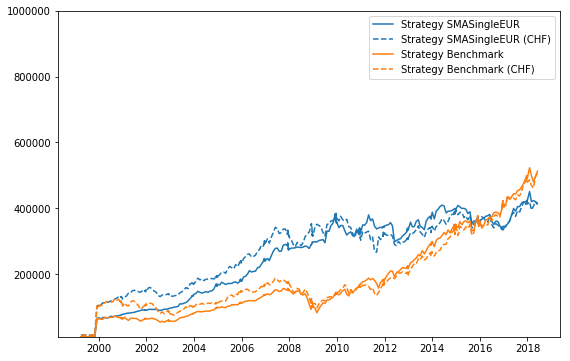

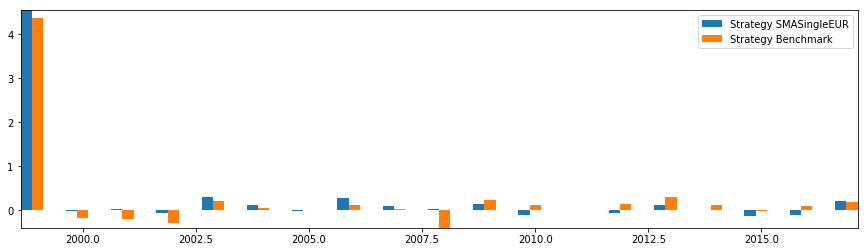

In [37]:
strats = [x[0] for x in results]  # flatten the result
plotwidth = 0.25
xreal = strats[0].datetime.plot()
xlen = len(xreal)
x = list(range(xlen))
ones = np.ones(xlen)

fmtdata = '%Y-%m-%d'
fig  = plt.figure(figsize=(9, 6))
fig2 = plt.figure(figsize=(15, 4))
ax   = fig.add_subplot(111)
ax2  = fig2.add_subplot(111)
fordata = fmt.MyDateFormatter(xreal, fmt=fmtdata)
ax.fmt_xdata = fordata
locmajor = loc.AutoDateLocator(xreal)
autofmt = loc.AutoDateFormatter(xreal, locmajor,defaultfmt=fmtdata)
plcolors = ['C0', 'C1', 'C2']
i=0
for strat in strats:
    broker = strat.observers.getbyname('broker')
    currencyadjuster = strat.observers.getbyname('portfoliocurrencyadjuster')
    cc = np.array(broker.lines[1].plot()) # Value in broker incl. cash
    ccc = np.array(currencyadjuster.lines[0].plot())
    (monidx, monthdates, ccmon) = MyUtils.ResampleDayToMonth(xreal,cc)
    (monidx, monthdates, cccmon) = MyUtils.ResampleDayToMonth(xreal,ccc)
    usdchf = strat.dnames['USDCHF'].close.plot() # Currency conversion
    startingvalue = cc[0]
    annret_dates, annret_returns = MyUtils.GetAnnualReturns(xreal,cc)
    ax.plot(monidx, ccmon, plcolors[i], label="Strategy " + str(strat.stratname))
    ax.plot(monidx,cccmon, plcolors[i], linestyle="--", label="Strategy " + str(strat.stratname) + " (CHF)")
    ax2.bar(annret_dates+(i-1)*plotwidth,annret_returns, width=plotwidth, label="Strategy " +str(strat.stratname))
    finalvalue = cc[-1]
    print(str(strat.stratname) + " final value: %.2f" % finalvalue)
    # Export the strategy
    datestr = np.array([datetime.date.fromordinal(int(dd)).isoformat() for dd in monthdates])
    cols = np.rec.fromarrays((datestr,ccmon, cccmon))
    np.savetxt("OutputData/Strat_" + strat.stratname + ".csv", cols, delimiter=',', fmt='%s, %.2f, %.2f')
    i += 1
ax.xaxis.set_major_locator(locmajor)
ax.xaxis.set_major_formatter(autofmt)
#ax.set_yscale('log')
ax.legend()
ax.set_ylim([0.1E5, 1E6])
ax2.autoscale(tight=True)
ax2.legend()